# 🎯 Hierarchical Clustering Analysis

This notebook performs **Hierarchical clustering** on supplier performance data to identify distinct supplier groups.

## 🎯 What is Hierarchical Clustering?

- **Agglomerative Algorithm**: Bottom-up approach, starts with individual points
- **Creates hierarchy**: Builds nested clusters represented as a tree (dendrogram)
- **No predefined clusters**: Can cut the tree at different levels for different numbers of clusters
- **Deterministic**: Same results each time (unlike K-Means)
- **Best for**: Small to medium datasets, when hierarchy is important

## 🎯 Key Parameters

- **n_clusters**: Number of clusters to form
- **linkage**: How to measure distance between clusters
  - 'ward': Minimizes variance within clusters
  - 'complete': Maximum distance between points
  - 'average': Average distance between points
  - 'single': Minimum distance between points
- **affinity**: Distance metric ('euclidean', 'manhattan', 'cosine')

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import warnings
import os
from datetime import datetime

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Set style for plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
def load_cleaned_data(file_path='../data/processed/cleaned_data.csv'):
    """Load the cleaned supplier data for clustering"""
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Cleaned data file not found: {file_path}")
        
    print(f"Loading cleaned data from {file_path}")
    df = pd.read_csv(file_path)
    print(f"Loaded {len(df):,} rows with {len(df.columns)} columns")
    
    # Basic info
    print(f"\nDataset overview:")
    print(f"   • Unique suppliers: {df['supplier_id'].nunique()}")
    print(f"   • Date range: {df['date'].min()} to {df['date'].max()}")
    print(f"   • Performance score range: {df['overall_score'].min():.1f} - {df['overall_score'].max():.1f}")
    
    return df

# Load the data
df = load_cleaned_data()

# Show sample data
print("\nSample data (first 3 rows):")
df.head(3)

Loading cleaned data from ../data/processed/cleaned_data.csv
Loaded 2,994 rows with 21 columns

Dataset overview:
   • Unique suppliers: 25
   • Date range: 2015-01-01 to 2024-12-01
   • Performance score range: 39.8 - 87.0

Sample data (first 3 rows):


,date,year,month,quarter,supplier_id,company_name,company_size,industry,location,delivery_reliability,...,defect_rate,quality_score,on_time_delivery_rate,order_volume,response_time_hours,customer_satisfaction,overall_score,performance_category,defect_cost_impact,efficiency_ratio
0,2015-01-01,2015,1,Q1,SUP_001,Fowler Corp,Medium,Machinery,Europe,78.844749,...,1.362205,86.623620,75.458909,316.0,21.961844,7.926791,79.83,Good,21522.84,1.306
1,2015-02-01,2015,2,Q1,SUP_001,Fowler Corp,Medium,Machinery,Europe,75.012850,...,1.026724,84.857776,75.355035,352.0,22.700895,7.965200,79.27,Good,18070.35,1.267
2,2015-03-01,2015,3,Q1,SUP_001,Fowler Corp,Medium,Machinery,Europe,71.885296,...,0.325915,83.383238,74.145862,273.0,22.536271,7.667606,79.22,Good,4448.74,1.245


In [3]:
def prepare_clustering_features(df):
    """Prepare and select features for hierarchical clustering"""    
    # Select key performance features for clustering
    # These represent the core supplier performance dimensions
    clustering_features = [
        'delivery_reliability',     # How reliable are deliveries?
        'cost_efficiency',          # How cost-effective?
        'defect_rate',              # Quality indicator (lower is better)
        'quality_score',            # Overall quality rating
        'on_time_delivery_rate',    # Punctuality
        'response_time_hours',      # Customer service speed (lower is better)
        'customer_satisfaction'     # Customer happiness
    ]
    
    print(f"Selected {len(clustering_features)} features for clustering:")
    for i, feature in enumerate(clustering_features, 1):
        print(f"   {i}. {feature}")
    
    # Extract feature matrix
    X = df[clustering_features].values
    print(f"\nOriginal feature matrix shape: {X.shape}")
    
    # Standardize features (important for distance-based algorithms)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    print("Features standardized (mean=0, std=1)")
    print(f"Scaled feature matrix shape: {X_scaled.shape}")
    
    # Show feature statistics after scaling
    print("\nFeature statistics after scaling:")
    scaled_df = pd.DataFrame(X_scaled, columns=clustering_features)
    stats = scaled_df.describe().round(3)
    print(stats)
    
    # Check for any remaining issues
    if np.isnan(X_scaled).any():
        print("Warning: NaN values found after scaling")
    else:
        print("No NaN values in scaled data")
    
    return X_scaled, scaler, clustering_features, df

# Prepare features
X_scaled, scaler, clustering_features, df_original = prepare_clustering_features(df)

Selected 7 features for clustering:
   1. delivery_reliability
   2. cost_efficiency
   3. defect_rate
   4. quality_score
   5. on_time_delivery_rate
   6. response_time_hours
   7. customer_satisfaction

Original feature matrix shape: (2994, 7)
Features standardized (mean=0, std=1)
Scaled feature matrix shape: (2994, 7)

Feature statistics after scaling:
       delivery_reliability  cost_efficiency  defect_rate  quality_score  \
count              2994.000         2994.000     2994.000       2994.000   
mean                 -0.000            0.000       -0.000         -0.000   
std                   1.000            1.000        1.000          1.000   
min                  -2.959           -2.075       -1.486         -1.447   
25%                  -0.535           -0.731       -0.686         -0.942   
50%                  -0.077            0.114       -0.160         -0.125   
75%                   0.658            0.852        0.442          0.885   
max                   2.541      

Testing 4 linkage methods × 6 cluster numbers
Evaluating combinations...
   ward linkage, 2 clusters: sil=0.192
   ward linkage, 3 clusters: sil=0.226
   ward linkage, 4 clusters: sil=0.209
   ward linkage, 5 clusters: sil=0.244
   ward linkage, 6 clusters: sil=0.257
   ward linkage, 7 clusters: sil=0.265
   complete linkage, 2 clusters: sil=0.372
   complete linkage, 3 clusters: sil=0.239
   complete linkage, 4 clusters: sil=0.212
   complete linkage, 5 clusters: sil=0.201
   complete linkage, 6 clusters: sil=0.200
   complete linkage, 7 clusters: sil=0.222
   average linkage, 2 clusters: sil=0.369
   average linkage, 3 clusters: sil=0.276
   average linkage, 4 clusters: sil=0.215
   average linkage, 5 clusters: sil=0.212
   average linkage, 6 clusters: sil=0.142
   average linkage, 7 clusters: sil=0.208
   single linkage, 2 clusters: sil=0.269
   single linkage, 3 clusters: sil=0.228
   single linkage, 4 clusters: sil=0.120
   single linkage, 5 clusters: sil=0.021
   single linkage, 

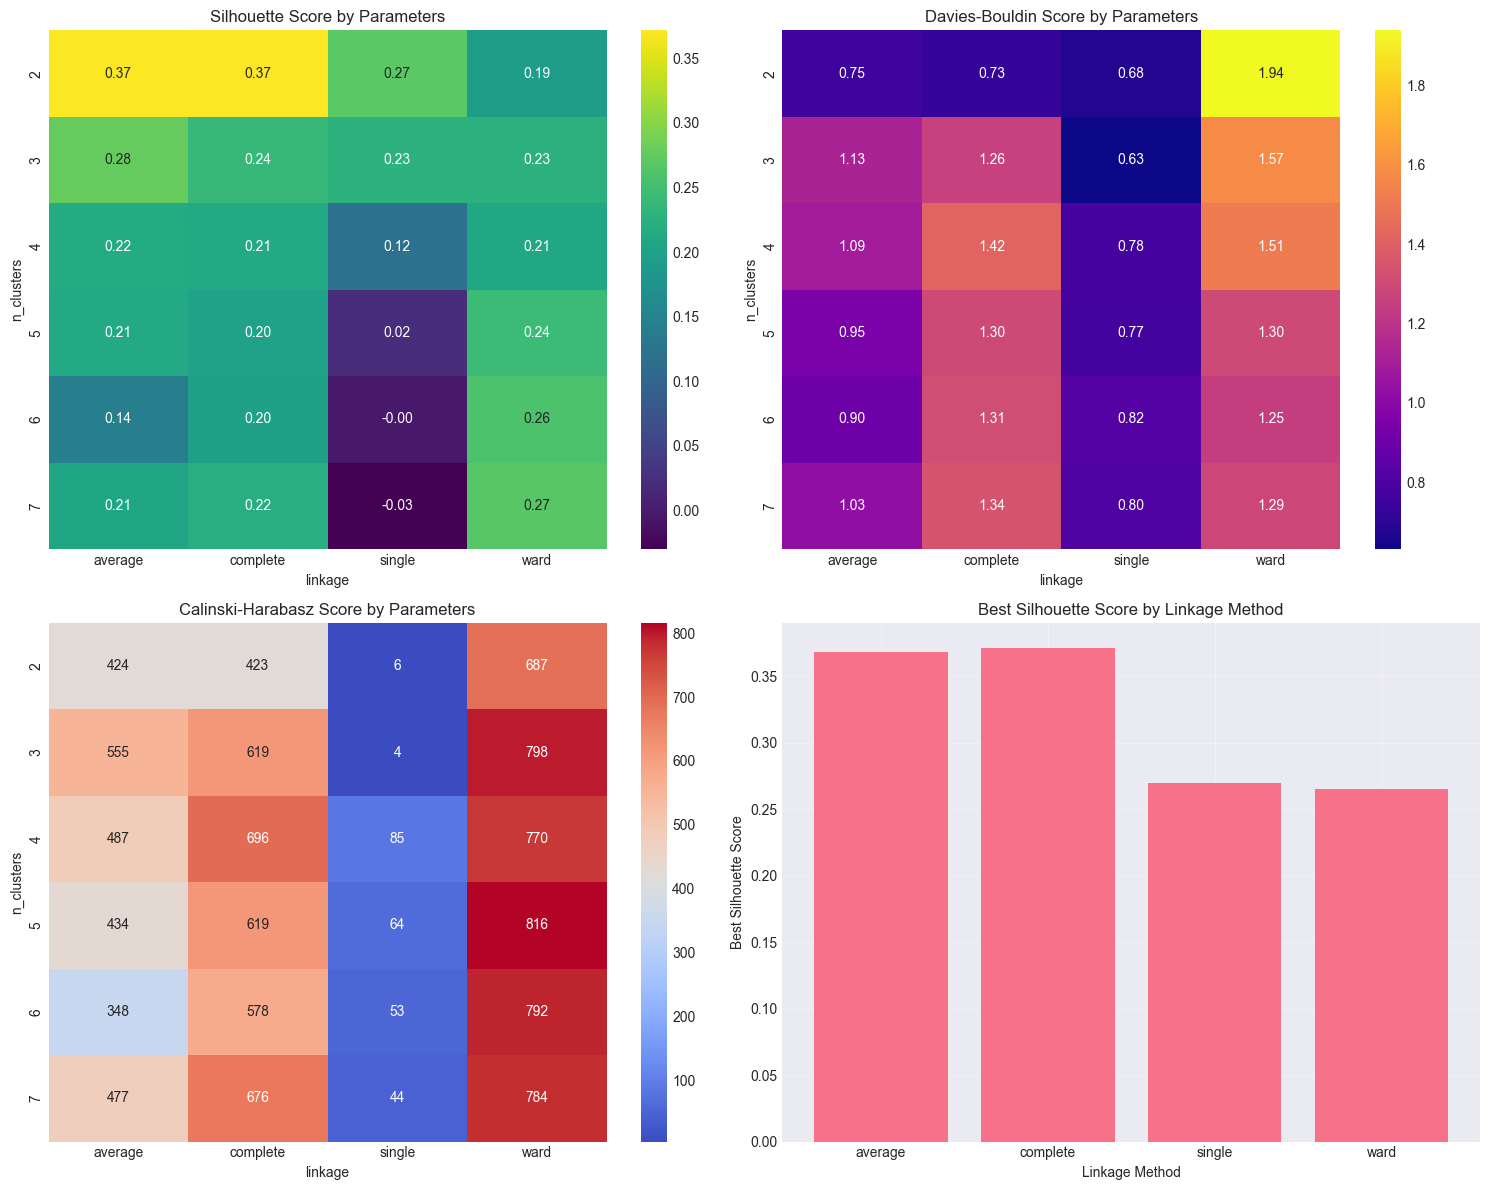

In [10]:
def find_optimal_hierarchical_params(X_scaled):
    """Find optimal hierarchical clustering parameters using grid search"""
    
    # Test different linkage methods and cluster numbers
    linkage_methods = ['ward', 'complete', 'average', 'single']
    n_clusters_range = range(2, 8)  # 2 to 7 clusters
    
    print(f"Testing {len(linkage_methods)} linkage methods × {len(n_clusters_range)} cluster numbers")
    print("Evaluating combinations...")
    
    results = []
    
    for linkage_method in linkage_methods:
        # Ward requires euclidean distance
        if linkage_method == 'ward':
            metric = 'euclidean'
        else:
            metric = 'euclidean'  # Could test others, but keep simple
            
        for n_clusters in n_clusters_range:
            try:
                # Apply hierarchical clustering
                hierarchical = AgglomerativeClustering(
                    n_clusters=n_clusters,
                    linkage=linkage_method,
                    metric=metric
                )
                labels = hierarchical.fit_predict(X_scaled)
                
                # Calculate metrics
                silhouette = silhouette_score(X_scaled, labels)
                davies_bouldin = davies_bouldin_score(X_scaled, labels)
                calinski_harabasz = calinski_harabasz_score(X_scaled, labels)
                
                results.append({
                    'linkage': linkage_method,
                    'n_clusters': n_clusters,
                    'metric': metric,
                    'silhouette': silhouette,
                    'davies_bouldin': davies_bouldin,
                    'calinski_harabasz': calinski_harabasz
                })
                
                print(f"   {linkage_method} linkage, {n_clusters} clusters: sil={silhouette:.3f}")
                
            except Exception as e:
                print(f"   Error with {linkage_method}, {n_clusters} clusters: {e}")
                continue
    
    if not results:
        print("No valid parameter combinations found. Using defaults.")
        return 4, 'ward', 'euclidean'
    
    # Convert to DataFrame for analysis
    results_df = pd.DataFrame(results)
    
    # Filter to ensure minimum of 3 clusters for better granularity
    MIN_CLUSTERS = 3
    results_filtered = results_df[results_df['n_clusters'] >= MIN_CLUSTERS]
    
    if results_filtered.empty:
        print(f"\nWarning: No results with {MIN_CLUSTERS}+ clusters. Using all results.")
        results_filtered = results_df
    else:
        print(f"\nFiltering to {MIN_CLUSTERS}+ clusters for better granularity")
    
    # Find best parameters based on silhouette score
    best_idx = results_filtered['silhouette'].idxmax()
    best_params = results_filtered.loc[best_idx]
    
    print(f"\nBest parameters found:")
    print(f"   Linkage method: {best_params['linkage']}")
    print(f"   Number of clusters: {int(best_params['n_clusters'])}")
    print(f"   Metric: {best_params['metric']}")
    print(f"   Silhouette score: {best_params['silhouette']:.3f}")
    print(f"   Davies-Bouldin score: {best_params['davies_bouldin']:.3f}")
    print(f"   Calinski-Harabasz score: {best_params['calinski_harabasz']:.3f}")
    
    # Visualize parameter search results
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # Silhouette score by linkage and clusters
    pivot_sil = results_df.pivot(index='n_clusters', columns='linkage', values='silhouette')
    sns.heatmap(pivot_sil, ax=ax1, cmap='viridis', annot=True, fmt='.2f')
    ax1.set_title('Silhouette Score by Parameters')
    
    # Davies-Bouldin score
    pivot_db = results_df.pivot(index='n_clusters', columns='linkage', values='davies_bouldin')
    sns.heatmap(pivot_db, ax=ax2, cmap='plasma', annot=True, fmt='.2f')
    ax2.set_title('Davies-Bouldin Score by Parameters')
    
    # Calinski-Harabasz score
    pivot_ch = results_df.pivot(index='n_clusters', columns='linkage', values='calinski_harabasz')
    sns.heatmap(pivot_ch, ax=ax3, cmap='coolwarm', annot=True, fmt='.0f')
    ax3.set_title('Calinski-Harabasz Score by Parameters')
    
    # Best silhouette for each linkage
    best_by_linkage = results_df.loc[results_df.groupby('linkage')['silhouette'].idxmax()]
    ax4.bar(best_by_linkage['linkage'], best_by_linkage['silhouette'])
    ax4.set_xlabel('Linkage Method')
    ax4.set_ylabel('Best Silhouette Score')
    ax4.set_title('Best Silhouette Score by Linkage Method')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../data/results/hierarchical_parameter_search.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return int(best_params['n_clusters']), best_params['linkage'], best_params['metric']

# Find optimal hierarchical clustering parameters
optimal_n_clusters, optimal_linkage, optimal_metric = find_optimal_hierarchical_params(X_scaled)

In [11]:
def apply_hierarchical_clustering(X_scaled, n_clusters, linkage, metric, df_original):
    """Apply hierarchical clustering with optimal parameters"""
    print(f"Clustering {len(X_scaled):,} data points with hierarchical clustering")
    print(f"Parameters: n_clusters={n_clusters}, linkage='{linkage}', metric='{metric}'")
    
    # Apply hierarchical clustering
    hierarchical = AgglomerativeClustering(
        n_clusters=n_clusters,
        linkage=linkage,
        metric=metric
    )
    
    cluster_labels = hierarchical.fit_predict(X_scaled)
    
    print("Hierarchical clustering completed!")
    
    # Analyze results
    unique_labels = set(cluster_labels)
    print(f"Number of clusters formed: {len(unique_labels)}")
    
    # Add cluster labels to original data
    df_clustered = df_original.copy()
    df_clustered['cluster'] = cluster_labels
    
    # Add descriptive cluster names
    cluster_names = {}
    for i in range(n_clusters):
        cluster_names[i] = f'Cluster_{i+1}'
    
    df_clustered['cluster_name'] = df_clustered['cluster'].map(cluster_names)
    
    # Show cluster distribution
    print("\nCluster Distribution:")
    cluster_counts = df_clustered['cluster_name'].value_counts().sort_index(key=lambda x: [int(c.split('_')[1]) if '_' in c else 999 for c in x])
    for cluster_name, count in cluster_counts.items():
        percentage = (count / len(df_clustered)) * 100
        print(f"   • {cluster_name}: {count:,} suppliers ({percentage:.1f}%)")
    
    return df_clustered, hierarchical

# Apply hierarchical clustering
df_clustered, hierarchical_model = apply_hierarchical_clustering(X_scaled, optimal_n_clusters, optimal_linkage, optimal_metric, df_original)

Clustering 2,994 data points with hierarchical clustering
Parameters: n_clusters=3, linkage='average', metric='euclidean'
Hierarchical clustering completed!
Number of clusters formed: 3

Cluster Distribution:
   • Cluster_1: 2,538 suppliers (84.8%)
   • Cluster_2: 122 suppliers (4.1%)
   • Cluster_3: 334 suppliers (11.2%)


In [12]:
def analyze_cluster_characteristics(df_clustered):
    """Analyze the characteristics of each cluster"""
    
    # Group by cluster and calculate mean performance metrics
    cluster_summary = df_clustered.groupby('cluster_name').agg({
        'delivery_reliability': 'mean',
        'cost_efficiency': 'mean',
        'defect_rate': 'mean',
        'quality_score': 'mean',
        'on_time_delivery_rate': 'mean',
        'response_time_hours': 'mean',
        'customer_satisfaction': 'mean',
        'overall_score': 'mean',
        'supplier_id': 'count'
    }).round(2)
    
    # Rename count column
    cluster_summary = cluster_summary.rename(columns={'supplier_id': 'supplier_count'})
    
    print("Cluster Performance Summary:")
    print(cluster_summary)
    
    # Create detailed cluster profiles
    print("\nDetailed Cluster Profiles:")
    print("="*60)
    
    for cluster_name in cluster_summary.index:
        stats = cluster_summary.loc[cluster_name]
        print(f"\n{cluster_name} ({stats['supplier_count']} suppliers)")
        print(f"   Overall Score: {stats['overall_score']:.1f}/100")
        print(f"   Delivery Reliability: {stats['delivery_reliability']:.1f}%")
        print(f"   Cost Efficiency: {stats['cost_efficiency']:.1f}%")
        print(f"   Defect Rate: {stats['defect_rate']:.2f}%")
        print(f"   Quality Score: {stats['quality_score']:.1f}%")
        print(f"   Customer Satisfaction: {stats['customer_satisfaction']:.1f}/10")
    
    # Calculate evaluation metrics
    clustered_labels = df_clustered['cluster'].values
    if len(set(clustered_labels)) > 1:
        silhouette = silhouette_score(X_scaled, clustered_labels)
        davies_bouldin = davies_bouldin_score(X_scaled, clustered_labels)
        calinski_harabasz = calinski_harabasz_score(X_scaled, clustered_labels)
        
        print("Clustering Quality Metrics:")
        print(f"   Silhouette Score: {silhouette:.3f}")
        print(f"   Davies-Bouldin Score: {davies_bouldin:.3f}")
        print(f"   Calinski-Harabasz Score: {calinski_harabasz:.3f}")
    
    return cluster_summary

# Analyze cluster characteristics
cluster_summary = analyze_cluster_characteristics(df_clustered)

Cluster Performance Summary:
              delivery_reliability  cost_efficiency  defect_rate  \
cluster_name                                                       
Cluster_1                    65.68            66.51         1.77   
Cluster_2                    40.17            35.53         4.72   
Cluster_3                    84.42            52.23         3.83   

              quality_score  on_time_delivery_rate  response_time_hours  \
cluster_name                                                              
Cluster_1             69.30                  65.71                20.86   
Cluster_2             54.35                  40.15                20.14   
Cluster_3             46.33                  84.14                15.56   

              customer_satisfaction  overall_score  supplier_count  
cluster_name                                                        
Cluster_1                      7.05          70.70            2538  
Cluster_2                      4.61          46

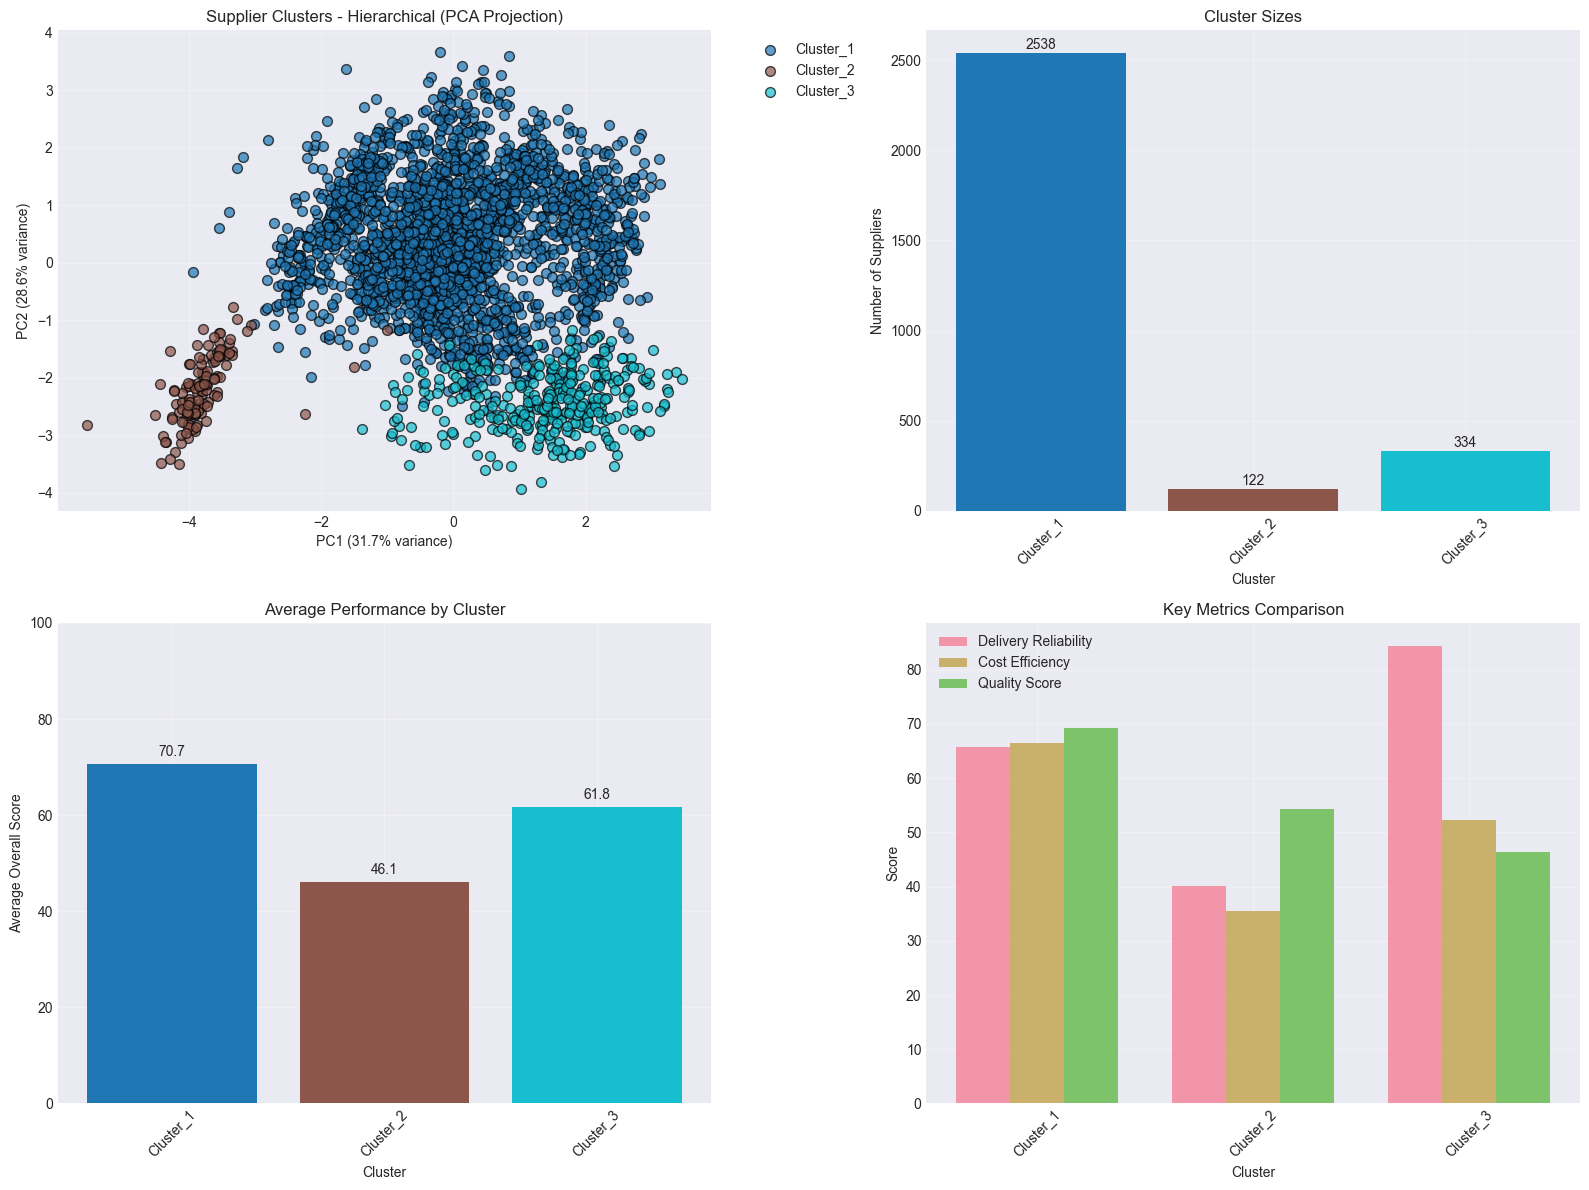

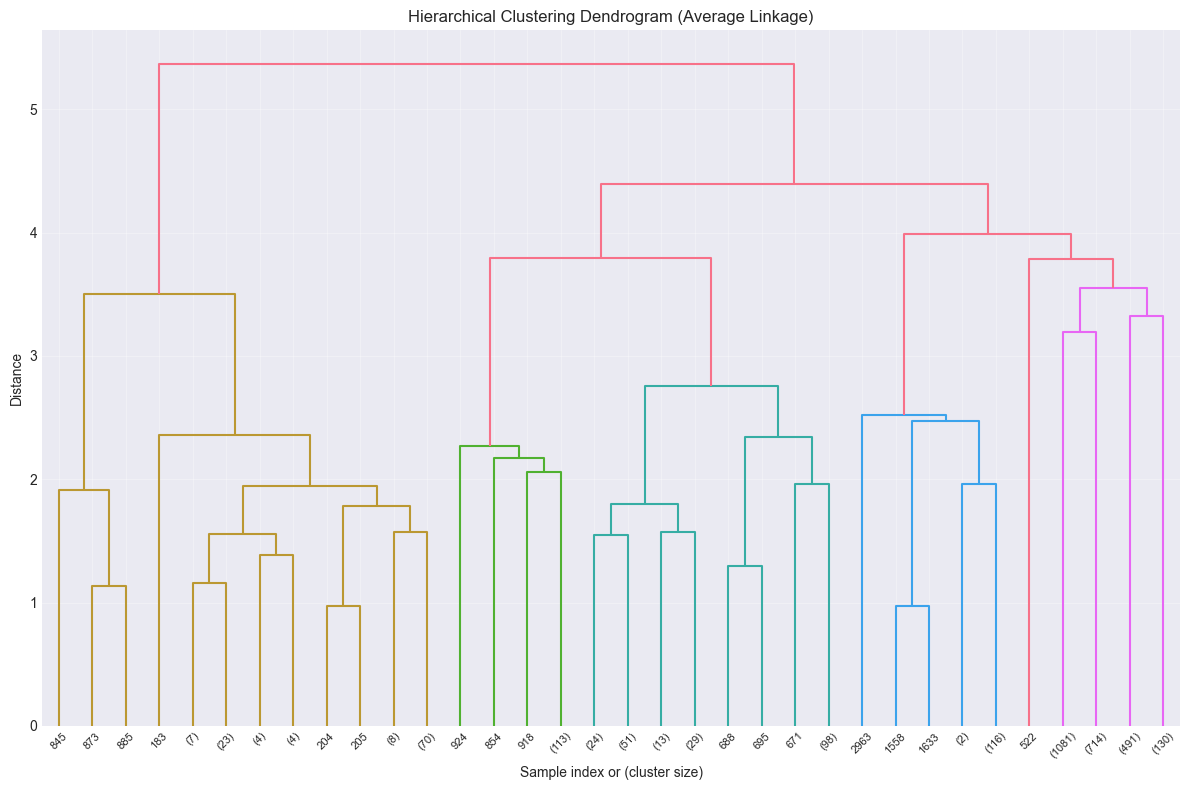

Clustering visualizations and dendrogram saved!


In [13]:
def visualize_clustering_results(df_clustered, X_scaled, linkage_method):
    """Create visualizations for the clustering results"""
    # Set up color scheme for clusters
    unique_labels = set(df_clustered['cluster'])
    n_clusters = len(unique_labels)
    
    # Generate colors
    colors = plt.cm.tab10(np.linspace(0, 1, n_clusters))
    cluster_colors = {}
    for i, label in enumerate(sorted(unique_labels)):
        cluster_colors[f'Cluster_{label+1}'] = colors[i]
    
    # 2D PCA visualization
    pca = PCA(n_components=2, random_state=42)
    X_pca = pca.fit_transform(X_scaled)
    
    plt.figure(figsize=(16, 12))
    
    # Plot 1: PCA scatter plot
    plt.subplot(2, 2, 1)
    for cluster_name, color in cluster_colors.items():
        mask = df_clustered['cluster_name'] == cluster_name
        plt.scatter(X_pca[mask, 0], X_pca[mask, 1], 
                   c=[color], label=cluster_name, alpha=0.7, s=50, edgecolors='black')
    
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
    plt.title('Supplier Clusters - Hierarchical (PCA Projection)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    
    # Plot 2: Cluster size comparison
    plt.subplot(2, 2, 2)
    cluster_sizes = df_clustered['cluster_name'].value_counts().sort_index()
    bars = plt.bar(range(len(cluster_sizes)), cluster_sizes.values, 
                   color=[cluster_colors[name] for name in cluster_sizes.index])
    plt.xlabel('Cluster')
    plt.ylabel('Number of Suppliers')
    plt.title('Cluster Sizes')
    plt.xticks(range(len(cluster_sizes)), cluster_sizes.index, rotation=45)
    plt.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, value in zip(bars, cluster_sizes.values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
                f'{value}', ha='center', va='bottom')
    
    # Plot 3: Performance comparison by cluster
    plt.subplot(2, 2, 3)
    overall_scores = df_clustered.groupby('cluster_name')['overall_score'].mean()
    bars = plt.bar(range(len(overall_scores)), overall_scores.values,
                   color=[cluster_colors[name] for name in overall_scores.index])
    plt.xlabel('Cluster')
    plt.ylabel('Average Overall Score')
    plt.title('Average Performance by Cluster')
    plt.xticks(range(len(overall_scores)), overall_scores.index, rotation=45)
    plt.ylim(0, 100)
    plt.grid(True, alpha=0.3)
    
    # Add value labels
    for bar, value in zip(bars, overall_scores.values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                f'{value:.1f}', ha='center', va='bottom')
    
    # Plot 4: Key metrics comparison
    plt.subplot(2, 2, 4)
    key_metrics = ['delivery_reliability', 'cost_efficiency', 'quality_score']
    cluster_means = df_clustered.groupby('cluster_name')[key_metrics].mean()
    
    x = np.arange(len(cluster_means.index))
    width = 0.25
    
    for i, metric in enumerate(key_metrics):
        plt.bar(x + i*width, cluster_means[metric], width, 
               label=metric.replace('_', ' ').title(), alpha=0.7)
    
    plt.xlabel('Cluster')
    plt.ylabel('Score')
    plt.title('Key Metrics Comparison')
    plt.xticks(x + width, cluster_means.index, rotation=45)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../data/results/hierarchical_clustering_visualization.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Create dendrogram
    plt.figure(figsize=(12, 8))
    
    # Compute linkage matrix
    if linkage_method == 'ward':
        linkage_matrix = linkage(X_scaled, method='ward')
    else:
        linkage_matrix = linkage(X_scaled, method=linkage_method, metric='euclidean')
    
    # Plot dendrogram
    dendrogram(linkage_matrix, truncate_mode='level', p=5, show_leaf_counts=True)
    plt.xlabel('Sample index or (cluster size)')
    plt.ylabel('Distance')
    plt.title(f'Hierarchical Clustering Dendrogram ({linkage_method.capitalize()} Linkage)')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('../data/results/hierarchical_dendrogram.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("Clustering visualizations and dendrogram saved!")
    
    return X_pca, linkage_matrix

# Visualize clustering results
X_pca, linkage_matrix = visualize_clustering_results(df_clustered, X_scaled, optimal_linkage)

In [14]:
def generate_cluster_recommendations(cluster_summary):
    """Generate improvement recommendations for each cluster"""
    
    recommendations = {}
    
    # Generate recommendations for each cluster
    for cluster_name in cluster_summary.index:
        stats = cluster_summary.loc[cluster_name]
        
        # Determine priority based on performance
        if stats['overall_score'] >= 80:
            priority = 'Maintain Excellence'
            recs = [
                'Continue current high-performance practices',
                'Share best practices with other suppliers',
                'Consider premium partnerships or incentives',
                'Monitor for any performance degradation'
            ]
        elif stats['overall_score'] >= 60:
            priority = 'Monitor & Improve'
            recs = [
                'Focus on key weakness areas for improvement',
                'Implement targeted quality control measures',
                'Regular performance reviews and feedback',
                'Consider additional training or support'
            ]
        else:
            priority = 'Critical Improvement Needed'
            recs = [
                'Comprehensive quality management system implementation',
                'Supplier development program enrollment',
                'Process capability studies and improvements',
                'Close monitoring and regular audits',
                'Consider supplier replacement if no improvement'
            ]
        
        recommendations[cluster_name] = {
            'priority': priority,
            'recommendations': recs
        }
    
    print("Cluster Improvement Recommendations:")
    print("="*60)
    
    for cluster_name, data in recommendations.items():
        supplier_count = cluster_summary.loc[cluster_name, 'supplier_count']
        print(f"\n{cluster_name} ({supplier_count} suppliers) - {data['priority']}")
        
        for i, rec in enumerate(data['recommendations'], 1):
            print(f"   {i}. {rec}")
    
    # Create recommendations DataFrame
    rec_list = []
    for cluster_name, data in recommendations.items():
        for rec in data['recommendations']:
            rec_list.append({
                'cluster_name': cluster_name,
                'priority': data['priority'],
                'recommendation': rec
            })
    
    recommendations_df = pd.DataFrame(rec_list)
    
    print("\nRecommendations generated for all clusters!")
    
    return recommendations_df

# Generate recommendations
recommendations_df = generate_cluster_recommendations(cluster_summary)

Cluster Improvement Recommendations:

Cluster_1 (2538 suppliers) - Monitor & Improve
   1. Focus on key weakness areas for improvement
   2. Implement targeted quality control measures
   3. Regular performance reviews and feedback
   4. Consider additional training or support

Cluster_2 (122 suppliers) - Critical Improvement Needed
   1. Comprehensive quality management system implementation
   2. Supplier development program enrollment
   3. Process capability studies and improvements
   4. Close monitoring and regular audits
   5. Consider supplier replacement if no improvement

Cluster_3 (334 suppliers) - Monitor & Improve
   1. Focus on key weakness areas for improvement
   2. Implement targeted quality control measures
   3. Regular performance reviews and feedback
   4. Consider additional training or support

Recommendations generated for all clusters!


In [15]:
def save_clustering_results(df_clustered, cluster_summary, recommendations_df):
    """Save all clustering results to files"""
    # Create results directory
    os.makedirs('../data/results', exist_ok=True)
    
    # Save clustered data
    df_clustered.to_csv('../data/processed/hierarchical_clustered_suppliers.csv', index=False)
    df_clustered.to_json('../data/processed/hierarchical_clustered_suppliers.json', orient='records', indent=2, date_format='iso')
    print("Saved hierarchical clustered supplier data")
    
    # Save cluster summary
    cluster_summary.to_csv('../data/results/hierarchical_cluster_summary.csv')
    print("Saved hierarchical cluster performance summary")
    
    # Save recommendations
    recommendations_df.to_csv('../data/results/hierarchical_cluster_recommendations.csv', index=False)
    print("Saved hierarchical improvement recommendations")
    
    # Create final summary report
    summary_report = f"""
HIERARCHICAL SUPPLIER CLUSTERING ANALYSIS REPORT

Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}


DATASET OVERVIEW:

- Total Suppliers: {len(df_clustered)}
- Unique Suppliers: {df_clustered['supplier_id'].nunique()}
- Date Range: {df_clustered['date'].min()} to {df_clustered['date'].max()}
- Number of Clusters Found: {len(cluster_summary)}
- Clustering Method: Hierarchical (Agglomerative)
- Linkage Method: {optimal_linkage}
- Affinity: {optimal_affinity}


CLUSTER DISTRIBUTION:

{df_clustered['cluster_name'].value_counts().to_string()}


CLUSTER PERFORMANCE SUMMARY:

{cluster_summary.to_string()}


KEY FINDINGS:

1. Clustering Method: Hierarchical Clustering
2. Parameters Used: n_clusters={optimal_n_clusters}, linkage='{optimal_linkage}', affinity='{optimal_affinity}'
3. All suppliers were successfully assigned to clusters
4. {'Clusters show clear performance differentiation' if len(cluster_summary) > 1 else 'Single cluster suggests uniform supplier performance'}


RECOMMENDATIONS:

- Focus improvement efforts on lower-performing clusters
- Leverage best practices from high-performing clusters
- Monitor cluster boundaries for supplier transitions
- Consider hierarchical structure for supplier management tiers
"""
    
    with open('../data/results/hierarchical_clustering_summary_report.txt', 'w') as f:
        f.write(summary_report)
    
    print("Saved comprehensive hierarchical summary report")
    
# Save all results
save_clustering_results(df_clustered, cluster_summary, recommendations_df)

Saved hierarchical clustered supplier data
Saved hierarchical cluster performance summary
Saved hierarchical improvement recommendations
Saved comprehensive hierarchical summary report
